In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import torch
from torch import nn
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from stacked_mnist import StackedMNISTData, DataMode

In [88]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            # nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            # nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, hidden_dim),
            nn.ReLU(True),
        )
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        hidden = self.encoder_lin(x)

        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [89]:
class Decoder(nn.Module):
    
    def __init__(self, z_dim,hidden_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(hidden_dim, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [90]:
d = 8
encoder = Encoder(z_dim=d,hidden_dim=128)
decoder = Decoder(z_dim=d,hidden_dim=128)

In [116]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        print(x.shape)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x)

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        print("z_loc:", z_loc)
        print("z_scale:", z_scale)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [117]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [98]:
### Training function
def train_epoch(svi, x):
    # Set train mode for both the encoder and the decoder
    train_loss = []
    epoch_loss = svi.step(x)
    return epoch_loss
    

In [99]:
### Testing function
def test_epoch(svi, x):
    # compute ELBO estimate and accumulate loss
    test_loss = svi.evaluate_loss(x)
    return test_loss

In [100]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)

In [118]:
import matplotlib.pyplot as plt
import random 
num_epochs = 5000
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   img_train, labels_train = generator.get_random_batch(training=True)
   img_test, labels_test = generator.get_random_batch(training=False)
   #print(img_train[0])
   #img = img_train[0]
   #plt.imshow(np.array(img).reshape((28, 28)))


   img_train = torch.tensor(img_train)
   img_train = img_train.type(torch.FloatTensor)
   img_test = torch.tensor(img_test)
   img_test = img_test.type(torch.FloatTensor)
   train_loss = train_epoch(svi, img_train)
   val_loss = test_epoch(svi, img_test)
   print(f"Epoch {epoch+1}/{num_epochs} train loss: {train_loss}, val loss: {val_loss}")
   #print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)

torch.Size([256, 1, 28, 28])


ValueError: Shape mismatch inside plate('data') at site obs dim -1, 256 vs 28
                  Trace Shapes:                 
                   Param Sites:                 
 decoder$$$decoder_lin.0.weight       400  50   
   decoder$$$decoder_lin.0.bias           400   
 decoder$$$decoder_lin.2.weight       288 400   
   decoder$$$decoder_lin.2.bias           288   
decoder$$$decoder_conv.0.weight 32 16   3   3   
  decoder$$$decoder_conv.0.bias            16   
decoder$$$decoder_conv.1.weight            16   
  decoder$$$decoder_conv.1.bias            16   
decoder$$$decoder_conv.3.weight 16  8   3   3   
  decoder$$$decoder_conv.3.bias             8   
decoder$$$decoder_conv.4.weight             8   
  decoder$$$decoder_conv.4.bias             8   
decoder$$$decoder_conv.6.weight  8  1   3   3   
  decoder$$$decoder_conv.6.bias             1   
                  Sample Sites:                 
                      data dist             |   
                          value       256   |   
                    latent dist       256   | 50
                          value       256   | 50

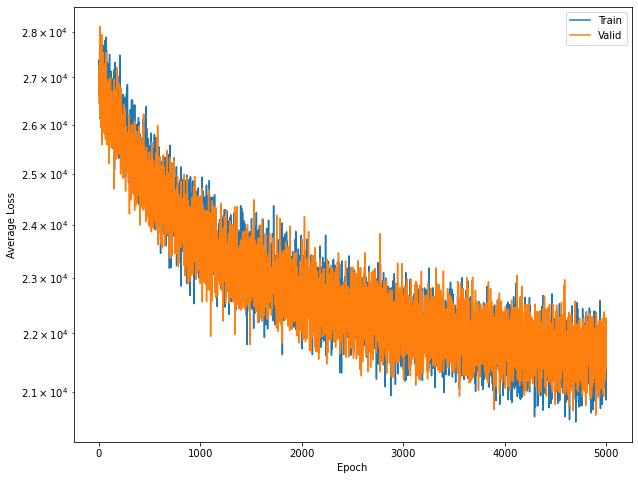

In [54]:
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

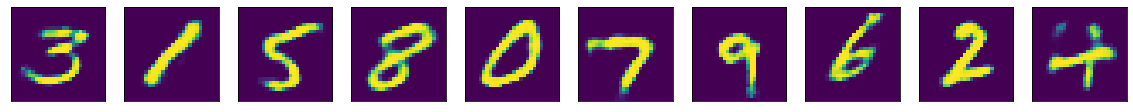

In [68]:
img_test, labels_test = generator.get_random_batch(training=False)
img_test = torch.tensor(img_test)
img_test = img_test.type(torch.FloatTensor)
x = vae.reconstruct_img(img_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x[i].detach().numpy().reshape((28, 28)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

tensor([ 0.4442, -2.2962,  1.0592,  0.2122,  1.6180,  0.8711, -0.2984, -1.6245])


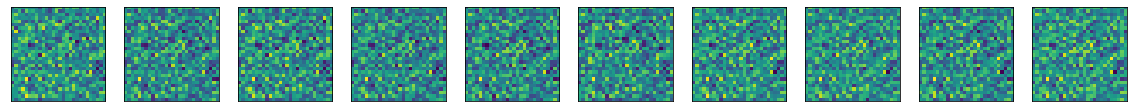

In [69]:
z = np.random.standard_normal((100, 8))
z = torch.Tensor(z)
print(z[0])
with torch.no_grad():
    x_hat = decoder(z)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(np.array(x_hat[i]).reshape((28, 28)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [52]:
from verification_net import VerificationNet
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=1000)
x = torch.Tensor(img)
x = x.type(torch.FloatTensor)

with torch.no_grad():
    auto_encoded_imgs = np.array(decoder(encoder(x)))
auto_encoded_imgs = auto_encoded_imgs.swapaxes(1, 2)
auto_encoded_imgs = auto_encoded_imgs.swapaxes(2, 3)
img = img.swapaxes(1, 2)
img = img.swapaxes(2, 3)

_, acc_ae = net.check_predictability(data=auto_encoded_imgs, correct_labels=labels)
print(f"Accuracy AE: {100 * acc_ae:.2f}%")
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy Original: {100 * acc_orig:.2f}%")



2022-02-28 17:39:28.122269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple